In [175]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 
from prophet import Prophet
from itertools import product as prd
from itertools import product

import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import norm, skew
from prophet import Prophet
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX

In [204]:
df = pd.read_csv('train.csv') 

In [205]:
df.head(10)

,date,store,item,quantity
0,01-01-13,1,1,13
1,01-02-13,1,1,11
2,01-03-13,1,1,14
3,01-04-13,1,1,13
4,01-05-13,1,1,10
5,01-06-13,1,1,12
6,01-07-13,1,1,10
7,01-08-13,1,1,9
8,01-09-13,1,1,12
9,01-10-13,1,1,9


In [200]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [189]:
df.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [190]:

print(df.isnull().any().sum(), ' / ', len(df.columns))

print(df.isnull().any(axis=1).sum(), ' / ', len(df))

0  /  4
0  /  913000


In [206]:

print (df.isna().sum())
print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)


date        0
store       0
item        0
quantity    0
dtype: int64
Null to Dataset Ratio in Dates:  0.0


C:\Users\BS-670\AppData\Local\Temp\ipykernel_18912\693744242.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print ('Null to Dataset Ratio in Dates: ',df.isnull().sum()[3]/df.shape[0]*100)


In [192]:
 
# df.dropna(axis=0, inplace=True)
# df.reset_index(drop=True)
# df.sort_values('Date')[10:20] 

In [54]:
# df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
# df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

# #Next step is to change the data type.
# df['Order_Demand'] = df['Order_Demand'].astype('int64')

In [194]:
df['date'].min() , df['date'].max()

('2013-01-01', '2017-12-31')

In [56]:
# df = df[(df['Date']>='2012-01-01') & (df['Date']<='2016-12-31')].sort_values('Date', ascending=True)

C:\Users\BS-670\AppData\Local\Temp\ipykernel_18912\610277298.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['sales'], fit=norm)
C:\Users\BS-670\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


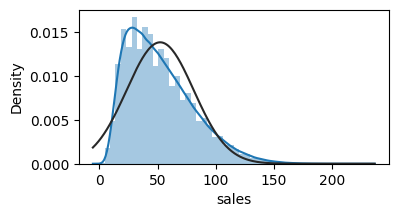

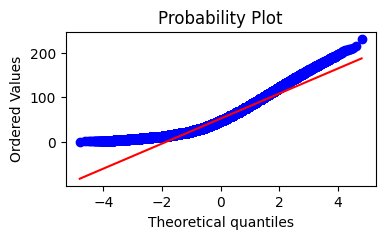

In [197]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sns.distplot(df['quantity'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['quantity'], plot=plt)
plt.show()

In [198]:
df['quantity'].skew()

0.8671122960235805

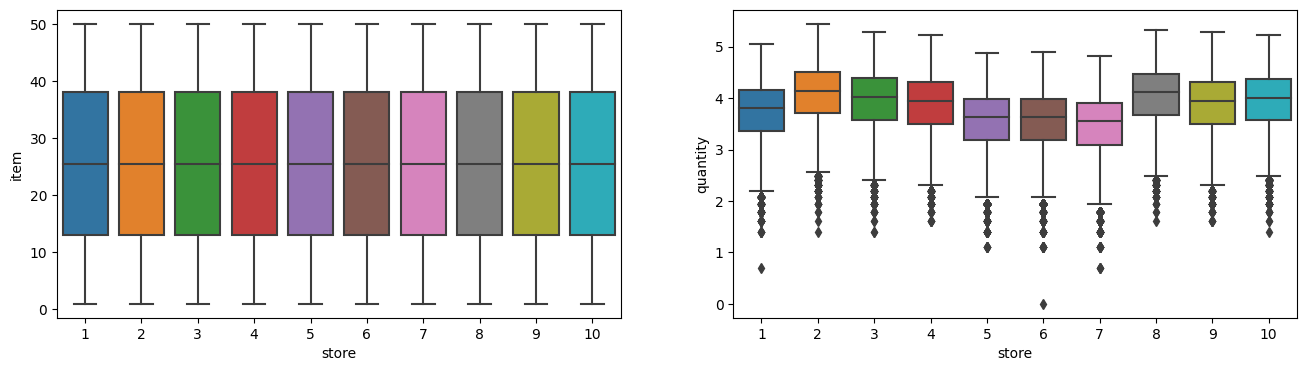

In [211]:

from matplotlib import rcParams

rcParams['figure.figsize'] = 16,4
f, axes = plt.subplots(1, 2)

fig3 = sns.boxplot( x = df['store'],y = df['item'], ax = axes[0])
#Data with Log Transformation
fig4 = sns.boxplot(x =  df['store'], y = np.log1p(df['quantity']),ax = axes[1])

del fig3, fig4

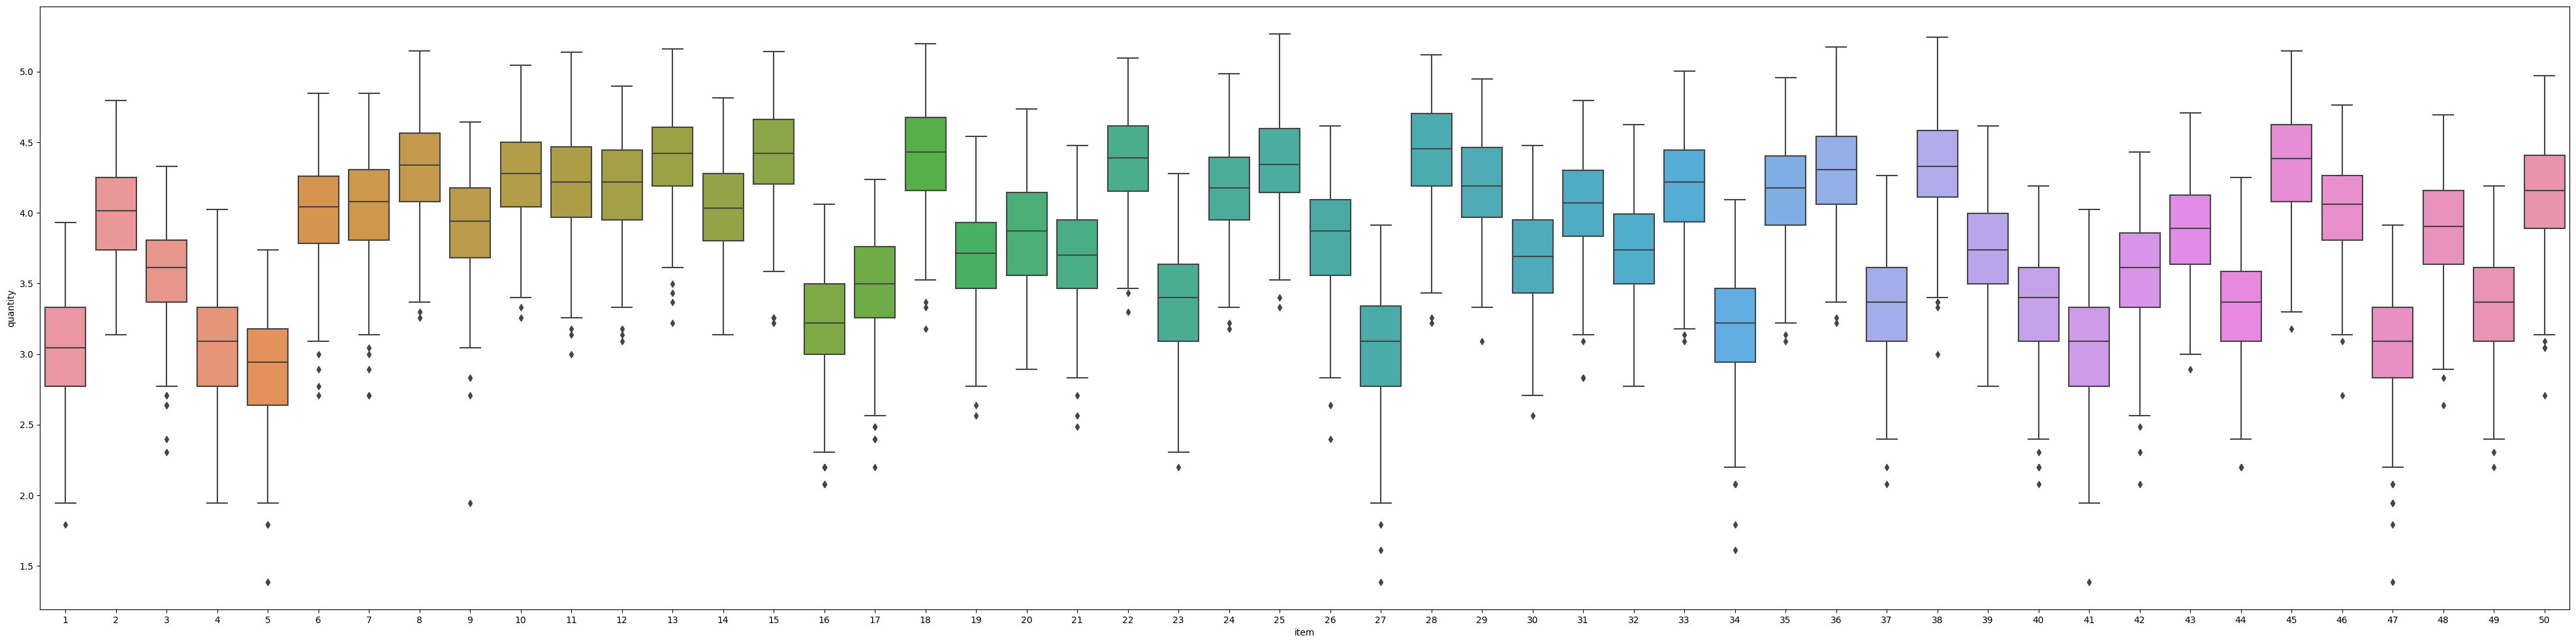

In [213]:
#Lets check the Orders by Product Category.
rcParams['figure.figsize'] = 50,12
#Taking subset of data temporarily for in memory compute.
df_temp = df.sample(n=20000).reset_index()
fig5 = sns.boxplot(x = df_temp['item'].sort_values(),y = np.log1p(df_temp['quantity']))
del df_temp, fig5

In [214]:
df.groupby('date')['quantity'].sum().reset_index()

,date,quantity
0,01-01-13,13696
1,01-01-14,15556
2,01-01-15,17226
3,01-01-16,20158
4,01-01-17,23709
...,...,...
1821,12-31-13,15044
1822,12-31-14,17238
1823,12-31-15,19377
1824,12-31-16,23792


In [89]:
df.shape

(847998, 4)

In [14]:
df['Product_Category'].value_counts()

Product_Category
Category_019    481099
Category_005    101671
Category_001     97787
Category_007     82402
Category_021     52011
Category_006     35577
Category_028     31302
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14803
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2280
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: count, dtype: int64

In [18]:
df['Product_Code'].value_counts()

Product_Code
Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
                ...  
Product_1912        2
Product_1703        1
Product_0465        1
Product_2099        1
Product_0853        1
Name: count, Length: 2160, dtype: int64

In [90]:
df = df.reset_index() 

In [215]:
df['date'] = pd.to_datetime(df['date'])

C:\Users\BS-670\AppData\Local\Temp\ipykernel_18912\3532345252.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [216]:
df = df.set_index('date') 

In [217]:
df.head()

,store,item,quantity
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [218]:
df['store_item'] = 'store' + df['store'].astype(str) + '_item' + df['item'].astype(str)


In [219]:
df.head()

,store,item,quantity,store_item
date,,,,
2013-01-01,1,1,13,store1_item1
2013-01-02,1,1,11,store1_item1
2013-01-03,1,1,14,store1_item1
2013-01-04,1,1,13,store1_item1
2013-01-05,1,1,10,store1_item1


In [227]:
df.groupby('store_item')['quantity'].sum().sort_values(ascending=False)

store_item
store2_item28    205677
store2_item15    205569
store2_item18    197422
store8_item15    197295
store2_item13    197031
                  ...  
store7_item27     27780
store7_item1      27681
store5_item5      25722
store6_item5      25369
store7_item5      23252
Name: quantity, Length: 500, dtype: int64

In [236]:
products = df[df['store_item'].isin(['store2_item28', 'store2_item15', 'store2_item18', 'store8_item15', 'store2_item13'])]

In [238]:
products.head()

,store,item,quantity,store_item
date,,,,
2013-01-01,2,13,51,store2_item13
2013-01-02,2,13,58,store2_item13
2013-01-03,2,13,49,store2_item13
2013-01-04,2,13,53,store2_item13
2013-01-05,2,13,67,store2_item13


In [239]:
products = products[['store_item', 'quantity']].reset_index()
products.head()

,date,store_item,quantity
0,2013-01-01,store2_item13,51
1,2013-01-02,store2_item13,58
2,2013-01-03,store2_item13,49
3,2013-01-04,store2_item13,53
4,2013-01-05,store2_item13,67


In [230]:
def ready_data(df):
    train = pd.DataFrame({
        'ds': df[:int(len(df)*0.8)].index, 
        'y': df[:int(len(df)*0.8)]['quantity'].values})
    validation = pd.DataFrame({
        'ds': df[int(len(df)*0.8):].index, 
        'y': df[int(len(df)*0.8):]['quantity'].values})
    return train, validation

In [231]:
def apply_prophet(train_data, validation, params):
    model = Prophet(**params)
    model.fit(train_data)
   
    future = model.make_future_dataframe(periods=len(validation), freq='M')

    forecast = model.predict(future)
    r2 = r2_score(validation['y'], forecast[-len(validation):]['yhat'])
    rmse = root_mean_squared_error(validation['y'], forecast[-len(validation):]['yhat'])

    return r2, rmse, model

In [232]:
def param_tuning(train, test):
    params_grid = {
        'seasonality_mode': ['multiplicative', 'additive'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1],
        'growth':['linear'],
        'holidays_prior_scale':[0.1,0.3,0.5,0.7],
        'n_changepoints' : [1,2,3,4,5]
    }

    # Generate all combinations of hyperparameters
    params_combinations = list(prd(*params_grid.values()))

    # Evaluate Prophet models with different hyperparameters
    results = []
    for params in params_combinations:
        params_dict = dict(zip(params_grid.keys(), params))
        r2, rmse, model = apply_prophet(train, test, params_dict)
        results.append({'params': params_dict,'r2': r2, 'rmse': rmse, 'model': model})

    best_params = min(results, key=lambda x: x['rmse'])['params']
    return best_params


In [233]:
p_code = ['store2_item28', 'store2_item15', 'store2_item18', 'store8_item15', 'store2_item13']


In [240]:
## Parameter Tuning
best_params_dict = {}
for product in p_code:
    data = products[products['store_item'] == product]
    data = data.drop('store_item', axis =1).set_index('date')
    data = data.resample('MS').sum()
    train, test = ready_data(data)
    
    best_params = param_tuning(train, test)
    best_params_dict[product] = best_params

18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing
18:33:30 - cmdstanpy - INFO - Chain [1] start processing
18:33:30 - cmdstanpy - INFO - Chain [1] done processing
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1] done processing
18:33:31 - cmdstanpy - INFO - Chain [1] start processing
18:33:31 - cmdstanpy - INFO - Chain [1]

18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:33:46 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:47 - cmdstanpy - INFO - Chain [1] start processing
18:33:47 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] start processing
18:33:48 - cmdstanpy - INFO - Chain [1] done processing
18:33:48 - cmdstanpy - INFO - Chain [1] 

18:34:02 - cmdstanpy - INFO - Chain [1] done processing
18:34:02 - cmdstanpy - INFO - Chain [1] start processing
18:34:02 - cmdstanpy - INFO - Chain [1] done processing
18:34:02 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:03 - cmdstanpy - INFO - Chain [1] done processing
18:34:03 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] start processing
18:34:04 - cmdstanpy - INFO - Chain [1] done processing
18:34:04 - cmdstanpy - INFO - Chain [1] 

18:34:18 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:19 - cmdstanpy - INFO - Chain [1] start processing
18:34:19 - cmdstanpy - INFO - Chain [1] done processing
18:34:20 - cmdstanpy - INFO - Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
18:34:20 - cmdstanpy - INFO - Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
18:34:20 - cmdstanpy - INFO - Chain [1] start processing
18:34:20 - cmdstanpy - INFO - Chain [1] done processing
18:34:20 - cmdstanpy - INFO - Chain [1] 

18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:36 - cmdstanpy - INFO - Chain [1] done processing
18:34:36 - cmdstanpy - INFO - Chain [1] start processing
18:34:37 - cmdstanpy - INFO - Chain [1] done processing
18:34:37 - cmdstanpy - INFO - Chain [1] 

18:34:51 - cmdstanpy - INFO - Chain [1] done processing
18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
18:34:51 - cmdstanpy - INFO - Chain [1] start processing
18:34:51 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:52 - cmdstanpy - INFO - Chain [1] done processing
18:34:52 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] 

18:35:08 - cmdstanpy - INFO - Chain [1] done processing
18:35:08 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:09 - cmdstanpy - INFO - Chain [1] start processing
18:35:09 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] start processing
18:35:10 - cmdstanpy - INFO - Chain [1] done processing
18:35:10 - cmdstanpy - INFO - Chain [1] 

18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:25 - cmdstanpy - INFO - Chain [1] start processing
18:35:25 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
18:35:26 - cmdstanpy - INFO - Chain [1] start processing
18:35:26 - cmdstanpy - INFO - Chain [1] done processing
18:35:27 - cmdstanpy - INFO - Chain [1] 

18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:41 - cmdstanpy - INFO - Chain [1] done processing
18:35:41 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:42 - cmdstanpy - INFO - Chain [1] start processing
18:35:42 - cmdstanpy - INFO - Chain [1] done processing
18:35:43 - cmdstanpy - INFO - Chain [1] start processing
18:35:43 - cmdstanpy - INFO - Chain [1] done processing
18:35:43 - cmdstanpy - INFO - Chain [1] 

In [96]:
# products = products[['Order_Demand', 'Product_Code']].reset_index()

18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing


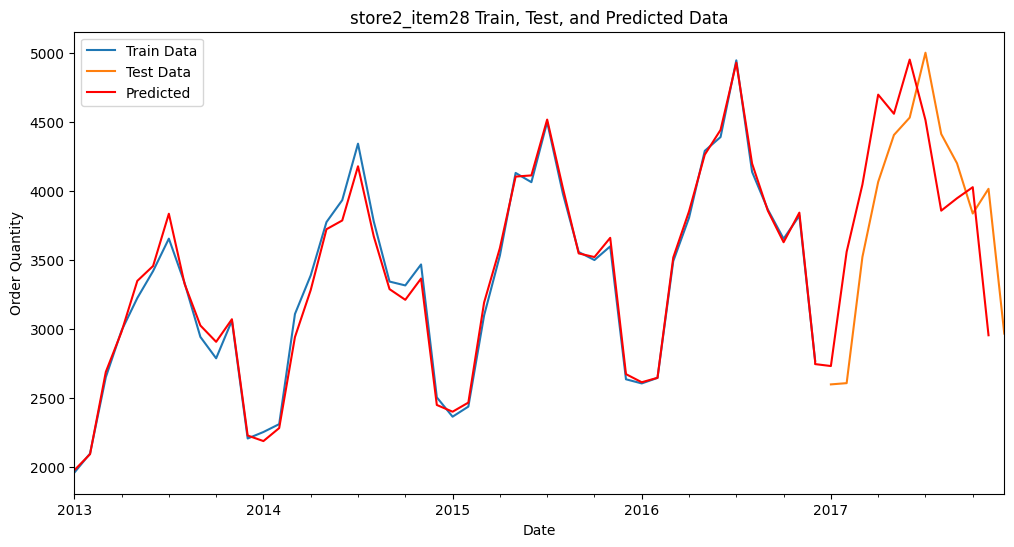

18:40:57 - cmdstanpy - INFO - Chain [1] start processing
18:40:57 - cmdstanpy - INFO - Chain [1] done processing


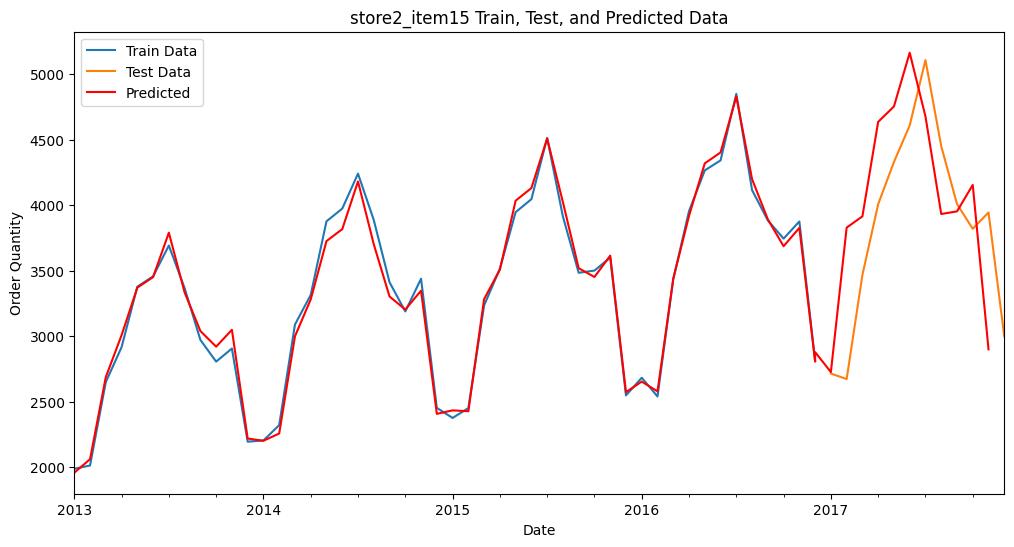

18:40:58 - cmdstanpy - INFO - Chain [1] start processing
18:40:58 - cmdstanpy - INFO - Chain [1] done processing


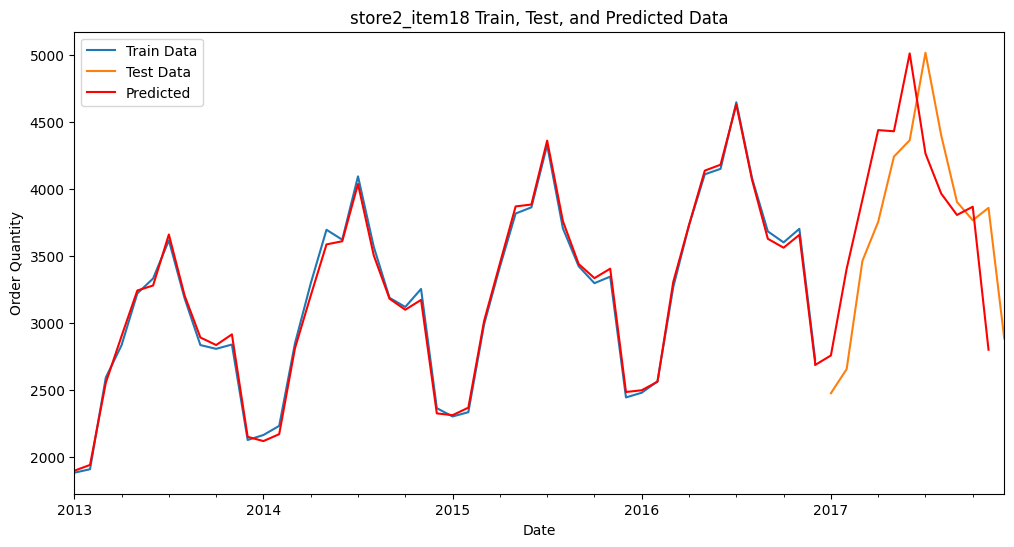

18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:59 - cmdstanpy - INFO - Chain [1] done processing


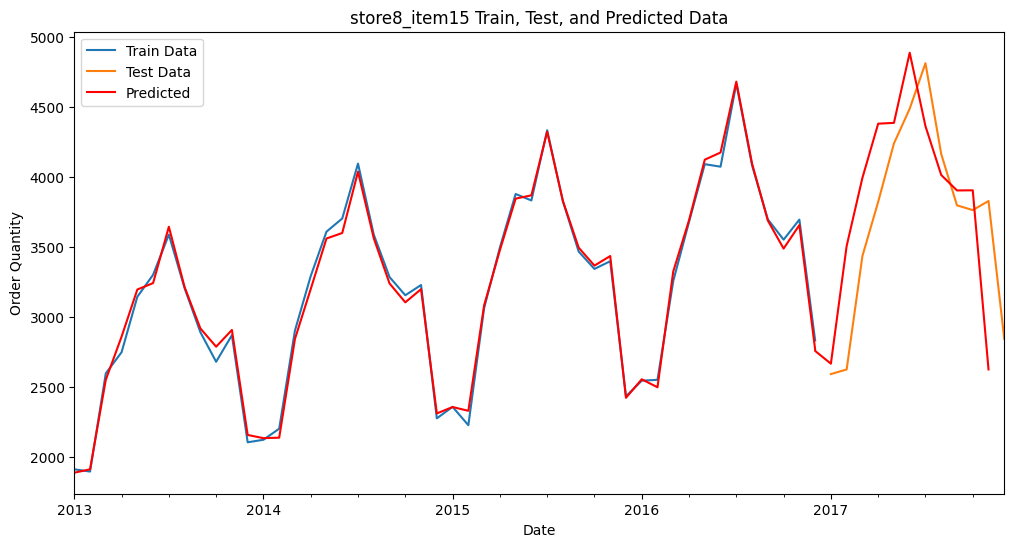

18:40:59 - cmdstanpy - INFO - Chain [1] start processing
18:40:59 - cmdstanpy - INFO - Chain [1] done processing


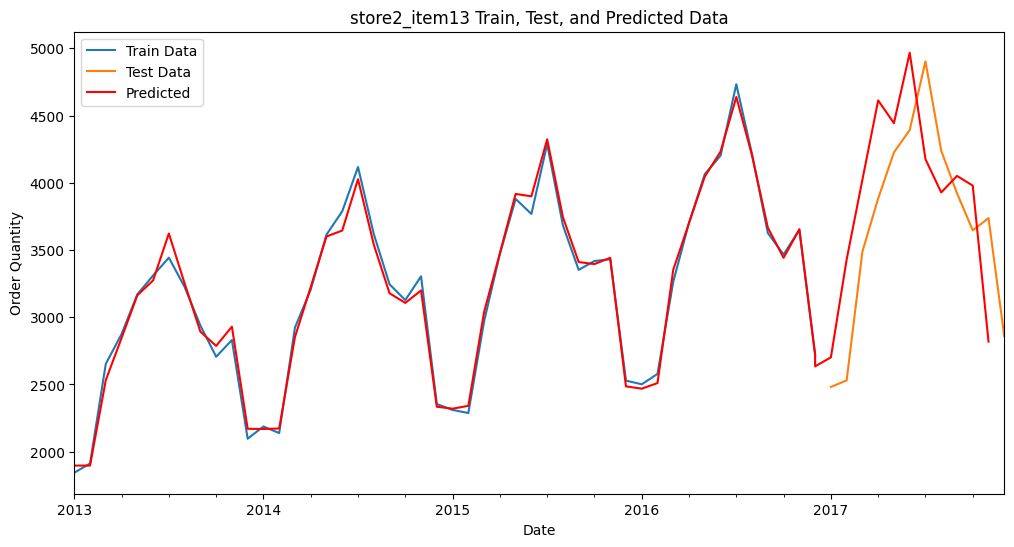

In [245]:

model_score = {}
for product in p_code:
    data = products[products['store_item'] == product]
    data = data.drop('store_item', axis =1).set_index('date')
    data = data.resample('MS').sum()
    train, test = ready_data(data)
    
    r2, rmse, model = apply_prophet(train, test, best_params_dict[product])
    model_score[product] = {'r2': r2, 'rmse': rmse, 'model': model}
    
    
    # Plotting 
    model = model_score[product]['model']
    future = model.make_future_dataframe(periods=len(test), freq='M')

    forecast = model.predict(future)

    fig, ax = plt.subplots(figsize=(12, 6))

    train.set_index('ds', inplace =True)
    train['y'].plot(ax=ax, label='Train Data')

    test.set_index('ds', inplace =True)
    test['y'].plot(ax=ax, label='Test Data')

    forecast.set_index('ds', inplace=True)
    forecast['yhat'].plot(ax=ax, label='Predicted', color='r')

    
    
    plt.title(product + ' Train, Test, and Predicted Data')
    plt.xlabel('Date')
    plt.ylabel('Order Quantity')
    plt.legend()
    plt.show()
    

In [246]:
for product in p_code:
    print(product, ':', model_score[product])
    print()

store2_item28 : {'r2': 0.959474313686262, 'rmse': 149.41610158200177, 'model': <prophet.forecaster.Prophet object at 0x000002BF9216EE90>}

store2_item15 : {'r2': 0.9345533832369604, 'rmse': 186.12727646558983, 'model': <prophet.forecaster.Prophet object at 0x000002BF9210EF90>}

store2_item18 : {'r2': 0.974712834078741, 'rmse': 115.30161912437445, 'model': <prophet.forecaster.Prophet object at 0x000002BF920AEE10>}

store8_item15 : {'r2': 0.9536131939456136, 'rmse': 147.02065263501675, 'model': <prophet.forecaster.Prophet object at 0x000002BF9806C390>}

store2_item13 : {'r2': 0.9255838014925897, 'rmse': 195.854477236525, 'model': <prophet.forecaster.Prophet object at 0x000002BF980FF610>}



In [139]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='30 days', horizon='365 days')
df_cv.head()

  0%|          | 0/2 [00:00<?, ?it/s]

16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:15 - cmdstanpy - INFO - Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-02-01,2.560574e+06,2.503288e+06,2.614777e+06,2204800,2014-01-02
1,2014-03-01,3.177403e+06,3.121826e+06,3.233660e+06,2704500,2014-01-02
2,2014-04-01,1.699995e+06,1.642939e+06,1.755208e+06,1979900,2014-01-02
3,2014-05-01,2.586163e+06,2.526665e+06,2.641104e+06,1713300,2014-01-02
4,2014-06-01,2.343036e+06,2.288321e+06,2.401221e+06,2016900,2014-01-02


In [140]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,1.046509e+11,323497.964888,321698.249034,0.133857,0.133857,0.125148,0.0
1,58 days,1.751060e+11,418456.747688,414338.371934,0.168111,0.168111,0.155058,0.0
2,59 days,2.137716e+11,462354.430129,462231.265379,0.201465,0.201465,0.209114,0.0
3,89 days,3.014802e+11,549072.118409,502103.672713,0.282063,0.282063,0.250556,0.0
4,119 days,5.316851e+11,729167.385127,687483.377337,0.395763,0.466108,0.328295,0.0
